In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-7c1c9c0627ad>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [3]:
# Create df of only Manhattan data, remove columns unhelpful to time series model 
df_man = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Qns', 'Accidents_Bkln', 'Accidents_SI',
                               'Accidents_Total'])

# Only use pre-COVID data for time series modeling
df_man = df_man.loc[:'2020-3-13']

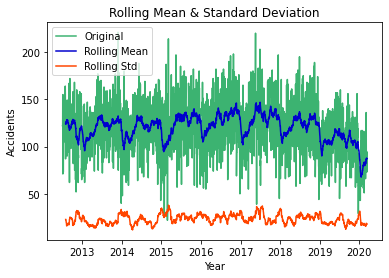

Test Statistic                   -4.079844
p-value                           0.001046
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [4]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_man['Accidents_Man'].rolling(window=30, center=False).mean()
roll_std = df_man['Accidents_Man'].rolling(window=30, center=False).std()

plt.plot(df_man['Accidents_Man'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_man['Accidents_Man'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# ARIMA Models

## Baseline Model: ARIMA with no Exogenous Variables

**ACF, PACF**

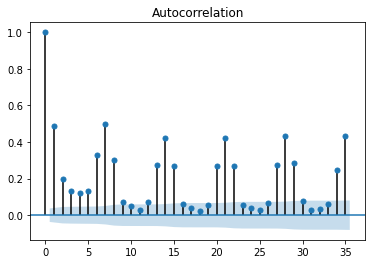

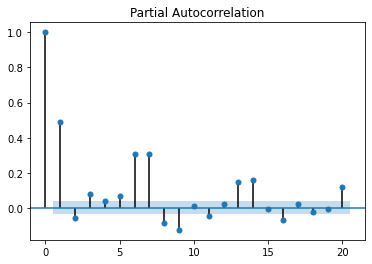

In [5]:
# ACF
plot_acf(df_man['Accidents_Man'], alpha=.05);

# PACF
plot_pacf(df_man['Accidents_Man'], alpha=.05, lags=20);

Based on the above ACF and PACF, when instantiating an ARIMA model, we would expect a relatively large number of MA terms due to the larger number of significant ACF points and a relatively small number of AR terms due to the small number of significant PACF points.

**Train-Test Split**

In [6]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_man) * 0.9)
df_man.iloc[split_point]

Accidents_Man         140
Season             Spring
Day of Week      Thursday
Weekend                 0
Holiday                 0
Name: 2019-06-06 00:00:00, dtype: object

In [16]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_man.index
y = df_man['Accidents_Man']

train = df_man.loc[:'2019-06-06']
test = df_man.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Man'] , test['Accidents_Man']

**Grid Search**

In [8]:
# Determine best parameters for ARIMA model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMA = []
for comb in pdq:
    try:
        mod = ARIMA(y_train, order=comb)
        output = mod.fit()
        ans_ARIMA.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =23674.080746830834
ARIMA (0, 0, 1) : AIC Calculated =23137.40235089366
ARIMA (0, 0, 2) : AIC Calculated =23105.74766192844
ARIMA (0, 0, 3) : AIC Calculated =23107.258895184015
ARIMA (0, 1, 0) : AIC Calculated =23945.42441579183
ARIMA (0, 1, 1) : AIC Calculated =23387.586153061795
ARIMA (0, 1, 2) : AIC Calculated =23020.751108141736
ARIMA (0, 1, 3) : AIC Calculated =23018.159106343726
ARIMA (0, 2, 0) : AIC Calculated =26174.65832725643
ARIMA (0, 2, 1) : AIC Calculated =23946.80083071508
ARIMA (0, 2, 2) : AIC Calculated =23394.02904851934
ARIMA (0, 2, 3) : AIC Calculated =23028.161791780447
ARIMA (1, 0, 0) : AIC Calculated =23127.244867038473
ARIMA (1, 0, 1) : AIC Calculated =23103.7182028996
ARIMA (1, 0, 2) : AIC Calculated =23015.45192035465
ARIMA (1, 0, 3) : AIC Calculated =23013.64600107241
ARIMA (1, 1, 0) : AIC Calculated =23831.623247176198
ARIMA (1, 1, 1) : AIC Calculated =23068.34249602826
ARIMA (1, 1, 2) : AIC Calculated =23019.345495296544
ARIM

In [9]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMA, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

,pdq,aic
34,"(3, 0, 3)",22562.438240
33,"(3, 0, 2)",22669.166849
38,"(3, 1, 3)",22719.490709
24,"(2, 0, 3)",22743.837316
27,"(2, 1, 2)",22998.401331
32,"(3, 0, 1)",22999.495436
37,"(3, 1, 2)",23000.296472
36,"(3, 1, 1)",23003.620865
26,"(2, 1, 1)",23005.842121
28,"(2, 1, 3)",23009.601341


**Narrowing Down Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [10]:
for pdq in df_AIC['pdq'][:10]:
    try:
        mod = ARIMA(y_train[:-1], order=pdq)
        mod_fit = mod.fit()
        print(mod_fit.summary())
    except:
        continue


                              ARMA Model Results                              
Dep. Variable:          Accidents_Man   No. Observations:                 2531
Model:                     ARMA(3, 3)   Log Likelihood              -11268.678
Method:                       css-mle   S.D. of innovations             20.732
Date:                Wed, 17 Feb 2021   AIC                          22553.356
Time:                        13:28:12   BIC                          22600.047
Sample:                    07-01-2012   HQIC                         22570.296
                         - 06-05-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 122.2164      1.219    100.276      0.000     119.828     124.605
ar.L1.Accidents_Man     2.1385        nan        nan        nan         nan         nan
ar.L2.Accidents_

                              ARMA Model Results                              
Dep. Variable:          Accidents_Man   No. Observations:                 2531
Model:                     ARMA(3, 1)   Log Likelihood              -11488.714
Method:                       css-mle   S.D. of innovations             22.649
Date:                Wed, 17 Feb 2021   AIC                          22989.428
Time:                        13:28:29   BIC                          23024.446
Sample:                    07-01-2012   HQIC                         23002.133
                         - 06-05-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 122.0355      2.259     54.029      0.000     117.609     126.462
ar.L1.Accidents_Man     1.3886      0.022     62.111      0.000       1.345       1.432
ar.L2.Accidents_

                             ARIMA Model Results                              
Dep. Variable:        D.Accidents_Man   No. Observations:                 2530
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -11492.526
Method:                       css-mle   S.D. of innovations             22.718
Date:                Wed, 17 Feb 2021   AIC                          22999.053
Time:                        13:28:33   BIC                          23039.904
Sample:                    07-02-2012   HQIC                         23013.875
                         - 06-05-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0047      0.027     -0.173      0.863      -0.058       0.049
ar.L1.D.Accidents_Man    -0.4304      0.083     -5.206      0.000      -0.592      -0.268
ar.L2.D.

From the above, we see that the following parameters have significant p-values:

(3,0,2)

(3,0,1)

We will now look at the next 10 lowest AIC scores to see if any of them are significant.

In [11]:
for pdq in df_AIC['pdq'][10:20]:
    try:
        mod = ARIMA(y_train[:-1], order=pdq)
        mod_fit = mod.fit()
        print(mod_fit.summary())
    except:
        continue


                             ARIMA Model Results                              
Dep. Variable:       D2.Accidents_Man   No. Observations:                 2529
Model:                 ARIMA(3, 2, 2)   Log Likelihood              -11493.407
Method:                       css-mle   S.D. of innovations             22.713
Date:                Wed, 17 Feb 2021   AIC                          23000.815
Time:                        13:28:37   BIC                          23041.664
Sample:                    07-03-2012   HQIC                         23015.636
                         - 06-05-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.111e-05   4.66e-05     -0.238      0.812      -0.000    8.03e-05
ar.L1.D2.Accidents_Man     0.3957      0.020     19.760      0.000       0.356       0.435
ar.L

                             ARIMA Model Results                              
Dep. Variable:        D.Accidents_Man   No. Observations:                 2530
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -11496.371
Method:                       css-mle   S.D. of innovations             22.752
Date:                Wed, 17 Feb 2021   AIC                          23004.742
Time:                        13:28:42   BIC                          23039.757
Sample:                    07-02-2012   HQIC                         23017.446
                         - 06-05-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0048      0.025     -0.193      0.847      -0.054       0.044
ar.L1.D.Accidents_Man    -0.4603      0.136     -3.383      0.001      -0.727      -0.194
ma.L1.D.

                             ARIMA Model Results                              
Dep. Variable:       D2.Accidents_Man   No. Observations:                 2529
Model:                 ARIMA(0, 2, 3)   Log Likelihood              -11503.916
Method:                       css-mle   S.D. of innovations             22.800
Date:                Wed, 17 Feb 2021   AIC                          23017.832
Time:                        13:28:46   BIC                          23047.010
Sample:                    07-03-2012   HQIC                         23028.419
                         - 06-05-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.095e-05   3.61e-05     -0.303      0.762   -8.17e-05    5.98e-05
ma.L1.D2.Accidents_Man    -1.5639        nan        nan        nan         nan         nan
ma.L

From the above, we see that the following parameters also have significant p-values:

(1,0,3)

(1,0,2)

We will compare RMSE values for these parameters as well as the prior two to determine our best ARIMA parameters.

**Determine Best ARIMA Model**

In [12]:
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# For loop to apply RMSE function to significant parameters
for pdq in [(3,0,2),(3,0,1),(1,0,3),(1,0,2)]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
    print(pdq,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)

(3, 0, 2) : RMSE:  32.74481934884086 AIC:  22661.269910263534
(3, 0, 1) : RMSE:  32.9693745725742 AIC:  22989.427651387996
(1, 0, 3) : RMSE:  32.83603799237759 AIC:  23003.510261172658
(1, 0, 2) : RMSE:  32.89362803734278 AIC:  23005.422274476237


The ARIMA model with parameters (3,0,2) is the best of the above due to its lowest RMSE and AIC score, albeit by a small margin, particularly for the RMSE. We will consider this our baseline model to which we will compare future ones.

In [17]:
# Define baseline model for future comparison
base = ARIMA(y_train[:-1], order=(3,0,2))
base_fit = base.fit()
base_pred = base_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
base_RMSE = RMSE(base_pred)
base_AIC = base_fit.aic

print('Baseline model RMSE: ', base_RMSE)
print('Baseline model RMSE adj for range: ',
      base_RMSE/(df_man['Accidents_Man'].max()-df_man['Accidents_Man'].min()))
print('Baseline model AIC: ', base_AIC)




Baseline model RMSE:  32.74481934884086
Baseline model RMSE adj for range:  0.16454683089869782
Baseline model AIC:  22661.269910263534


## Model #2: Introducing Exogenous Variables: ARIMAX Model

Now that we have our baseline ARIMA model, we will try incorporating exogenous variables with an ARIMAX model.

**Clean Data for ARIMAX Model**

In [14]:
# Turn exogenous variables into integers so they work in the model
# Season
df_man['Season'] = np.where(df_man['Season']=='Fall', 1, df_man['Season'])
df_man['Season'] = np.where(df_man['Season']=='Winter', 2, df_man['Season'])
df_man['Season'] = np.where(df_man['Season']=='Spring', 3, df_man['Season'])
df_man['Season'] = np.where(df_man['Season']=='Summer', 4, df_man['Season'])

# Day of Week
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Sunday', 1, df_man['Day of Week'])
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Monday', 2, df_man['Day of Week'])
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Tuesday', 3, df_man['Day of Week'])
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Wednesday', 4, df_man['Day of Week'])
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Thursday', 5, df_man['Day of Week'])
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Friday', 6, df_man['Day of Week'])
df_man['Day of Week'] = np.where(df_man['Day of Week']=='Saturday', 7, df_man['Day of Week'])

# Weekend (these turned into strings when the data was imported from the csv)
df_man['Weekend'] = np.where(df_man['Weekend']=='0', 0, df_man['Weekend'])
df_man['Weekend'] = np.where(df_man['Weekend']=='1', 1, df_man['Weekend'])

# Holiday (these turned into strings when the data was imported from the csv)
df_man['Holiday'] = np.where(df_man['Holiday']=='0', 0, df_man['Holiday'])
df_man['Holiday'] = np.where(df_man['Holiday']=='1', 1, df_man['Holiday'])



**Redefine Train-Test Split with Cleaned Data**

In [15]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_man.index
y = df_man['Accidents_Man']

train = df_man.loc[:'2019-06-06']
test = df_man.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Man'] , test['Accidents_Man']

In [16]:
# Make list of lists of exogenous data to be used in the model
list_of_lists = []
for column in list(train.iloc[:,1:].columns):
    list_of_lists.append(list(train[column]))
    
exog=np.column_stack(list_of_lists)


**Grid Search**

In [17]:
# Determine best parameters for ARIMAX model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMAX2 = []
for comb in pdq:
    try:
        mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=comb)
        output = mod.fit()
        ans_ARIMAX2.append([comb, output.aic])
        print('ARIMAX {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARIMAX (0, 0, 0) : AIC Calculated =22404.83319039494
ARIMAX (0, 0, 1) : AIC Calculated =22083.101067265357
ARIMAX (0, 0, 2) : AIC Calculated =21996.435167705542
ARIMAX (0, 0, 3) : AIC Calculated =21939.39586028383
ARIMAX (0, 1, 0) : AIC Calculated =22920.173084588445
ARIMAX (0, 1, 1) : AIC Calculated =22196.084251496686
ARIMAX (0, 1, 2) : AIC Calculated =22089.813876813518
ARIMAX (0, 1, 3) : AIC Calculated =22069.380657762536
ARIMAX (0, 2, 0) : AIC Calculated =25782.59928199445
ARIMAX (0, 2, 1) : AIC Calculated =nan
ARIMAX (0, 2, 2) : AIC Calculated =22475.26695538684
ARIMAX (0, 2, 3) : AIC Calculated =22393.77849595942
ARIMAX (1, 0, 0) : AIC Calculated =21959.281198316094
ARIMAX (1, 0, 1) : AIC Calculated =21818.597040286033
ARIMAX (1, 0, 2) : AIC Calculated =21787.240507608843
ARIMAX (1, 0, 3) : AIC Calculated =21781.980925400232
ARIMAX (1, 1, 0) : AIC Calculated =22579.116836008452
ARIMAX (1, 1, 1) : AIC Calculated =22059.764528718308
ARIMAX (1, 1, 2) : AIC Calculated =22053.3089884

In [18]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMAX2, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

,pdq,aic
37,"(3, 0, 2)",21776.233947
38,"(3, 0, 3)",21776.385635
26,"(2, 0, 3)",21776.417982
25,"(2, 0, 2)",21776.484361
36,"(3, 0, 1)",21777.952023
24,"(2, 0, 1)",21780.085212
15,"(1, 0, 3)",21781.980925
14,"(1, 0, 2)",21787.240508
13,"(1, 0, 1)",21818.597040
35,"(3, 0, 0)",21863.640354


**Determining Best Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [19]:
for pdq in df_AIC['pdq'][:10]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

                              ARMA Model Results                              
Dep. Variable:          Accidents_Man   No. Observations:                 2532
Model:                     ARMA(3, 2)   Log Likelihood              -10877.117
Method:                       css-mle   S.D. of innovations             17.757
Date:                Wed, 17 Feb 2021   AIC                          21776.234
Time:                        13:31:25   BIC                          21840.438
Sample:                    07-01-2012   HQIC                         21799.528
                         - 06-06-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 117.1846      3.316     35.342      0.000     110.686     123.683
x1                     -0.4492      0.925     -0.486      0.627      -2.262       1.364
x2              

                              ARMA Model Results                              
Dep. Variable:          Accidents_Man   No. Observations:                 2532
Model:                     ARMA(3, 1)   Log Likelihood              -10878.976
Method:                       css-mle   S.D. of innovations             17.770
Date:                Wed, 17 Feb 2021   AIC                          21777.952
Time:                        13:31:39   BIC                          21836.320
Sample:                    07-01-2012   HQIC                         21799.129
                         - 06-06-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 117.0565      3.266     35.841      0.000     110.655     123.458
x1                     -0.3594      0.939     -0.383      0.702      -2.200       1.481
x2              

                              ARMA Model Results                              
Dep. Variable:          Accidents_Man   No. Observations:                 2532
Model:                     ARMA(1, 1)   Log Likelihood              -10901.299
Method:                       css-mle   S.D. of innovations             17.928
Date:                Wed, 17 Feb 2021   AIC                          21818.597
Time:                        13:31:46   BIC                          21865.291
Sample:                    07-01-2012   HQIC                         21835.538
                         - 06-06-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 113.5505      2.600     43.678      0.000     108.455     118.646
x1                      0.7419      0.887      0.836      0.403      -0.996       2.480
x2              

We don't see any significant p values above, so will look at the next 10 lowest AIC scores.

In [20]:
for pdq in df_AIC['pdq'][10:20]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

                              ARMA Model Results                              
Dep. Variable:          Accidents_Man   No. Observations:                 2532
Model:                     ARMA(2, 0)   Log Likelihood              -10940.116
Method:                       css-mle   S.D. of innovations             18.206
Date:                Wed, 17 Feb 2021   AIC                          21896.231
Time:                        13:31:47   BIC                          21942.926
Sample:                    07-01-2012   HQIC                         21913.173
                         - 06-06-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 112.5509      1.898     59.289      0.000     108.830     116.272
x1                      1.3984      0.631      2.215      0.027       0.161       2.636
x2              

                             ARIMA Model Results                              
Dep. Variable:        D.Accidents_Man   No. Observations:                 2531
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -10986.644
Method:                       css-mle   S.D. of innovations             18.547
Date:                Wed, 17 Feb 2021   AIC                          21997.288
Time:                        13:32:10   BIC                          22067.325
Sample:                    07-02-2012   HQIC                         22022.699
                         - 06-06-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    17.2497      0.928     18.597      0.000      15.432      19.068
x1                       -0.0335      0.028     -1.191      0.234      -0.089       0.022
x2      

                             ARIMA Model Results                              
Dep. Variable:        D.Accidents_Man   No. Observations:                 2531
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -11012.643
Method:                       css-mle   S.D. of innovations             18.761
Date:                Wed, 17 Feb 2021   AIC                          22047.286
Time:                        13:32:29   BIC                          22111.486
Sample:                    07-02-2012   HQIC                         22070.579
                         - 06-06-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    17.6057      0.824     21.362      0.000      15.990      19.221
x1                       -0.0607      0.029     -2.086      0.037      -0.118      -0.004
x2      

From the above, we see that the following parameters have significant p values:

(2,0,0)

(0,0,3)

(1,0,0)

(0,0,2)

(1,1,3)

(2,1,2)


We will observe RMSE and AIC values for these to determine our best working model.

In [21]:
# For loop to apply RMSE function to significant parameters
for (pdq) in [(2,0,0),(0,0,3),(1,0,0),(0,0,1),(1,1,3),(2,1,2)]:
    mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
    mod_RMSE = RMSE(mod_pred)
    mod_AIC = mod_fit.aic
    print(pdq,' RMSE: ', mod_RMSE)
    print(pdq,' AIC: ', mod_AIC)  
    

(2, 0, 0)  RMSE:  33.80564551891482
(2, 0, 0)  AIC:  21896.231429198808
(0, 0, 3)  RMSE:  33.72057346338375
(0, 0, 3)  AIC:  21939.39586028383
(1, 0, 0)  RMSE:  33.54218049728444
(1, 0, 0)  AIC:  21959.281198316094
(0, 0, 1)  RMSE:  33.51109655415795
(0, 0, 1)  AIC:  22083.101067265357
(1, 1, 3)  RMSE:  102.20420847927417
(1, 1, 3)  AIC:  22045.2896496966
(2, 1, 2)  RMSE:  102.20908367636429
(2, 1, 2)  AIC:  22046.374037888334


The first four models above have very similar RMSEs and AICs. We will consider the model with parameters (0,0,1) to be our best ARIMAX model because it has the lowest RMSE and only slightly higher AIC than some others.

In [22]:
# Define ARIMAX model
ARIMAX = sm.tsa.ARIMA(endog=y_train, exog=exog, order=(0,0,1))
ARIMAX_fit = ARIMAX.fit()
ARIMAX_pred = ARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
ARIMAX_RMSE = RMSE(ARIMAX_pred)
ARIMAX_AIC = ARIMAX_fit.aic

# Compare ARIMA and ARIMAX model RMSEs and AICs

print('ARIMA model RMSE: ', base_RMSE)
print('ARIMA model AIC: ', base_AIC)

print('ARIMAX model RMSE: ', ARIMAX_RMSE)
print('ARIMAX model AIC: ', ARIMAX_AIC)



ARIMA model RMSE:  32.74481934884086
ARIMA model AIC:  22661.269910263534
ARIMAX model RMSE:  33.51109655415795
ARIMAX model AIC:  22083.101067265357


We see from the above that though our baseline model has a worse AIC score, it performs slightly better with RMSE. Since RMSE is what tells us more clearly how far off our predictions are, we will consider this the better model.

## Model #3: Introducing Seasonality: SARIMA Model

Or data is seasonal, so we would expect a SARIMA model to produce better results than our baseline ARIMA one.

**Resample Weekly Data**

Since data is seasonal by year, our period value would ordinarily be 365 observations. This is too large for a SARIMA model, so will create a df with weekly data and instead use a period value of 52.

In [6]:
# Create df of weekly data
df_man_wk = df_man.resample('W')
df_man_wk_mean = df_man_wk.mean()


In [7]:
# When we introduce exogenous data, the weekend column won't be valuable--remove it
df_man_wk_mean.drop(columns=['Weekend'], inplace=True)

# Change holiday column to be a 1 if there is any holiday that week,
# ie if the value is greater than 0
df_man_wk_mean['Holiday'] = np.where(df_man_wk_mean['Holiday']>0, 1, 0)

# Add in Season
df_man_wk_mean['Season'] = 0

def season(month,season):
    df_man_wk_mean['Season'] = np.where((df_man_wk_mean.index.month==month),
                                         season,df_man_wk_mean['Season'])

for month in range (1,4):
    season(month,2)
    
for month in range (4,7):
    season(month,3)
    
for month in range (7,10):
    season(month,4)

for month in range (10,13):
    season(month,1)

# Holiday
df_man_wk_mean['Holiday'] = np.where(df_man_wk_mean['Holiday']=='0',
                                      0, df_man_wk_mean['Holiday'])
df_man_wk_mean['Holiday'] = np.where(df_man_wk_mean['Holiday']=='1',
                                      1, df_man_wk_mean['Holiday'])

# Observe new df head
df_man_wk_mean.head()

,Accidents_Man,Holiday,Season
Date,,,
2012-07-01,122.000000,0,4
2012-07-08,113.571429,1,4
2012-07-15,122.571429,0,4
2012-07-22,128.857143,0,4
2012-07-29,132.000000,0,4


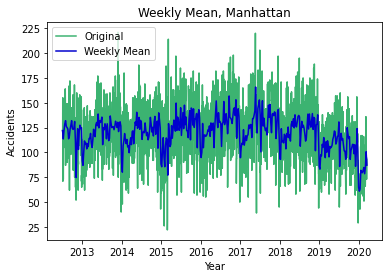

Test Statistic                  -3.523997
p-value                          0.007392
#Lags Used                       4.000000
Number of Observations Used    397.000000
dtype: float64

In [8]:
# Plot weekly data compared to daily
plt.plot(df_man['Accidents_Man'],color='mediumseagreen', label='Original')
plt.plot(df_man_wk_mean['Accidents_Man'], color='mediumblue', label='Weekly Mean')
plt.legend(loc='best')
plt.title('Weekly Mean, Manhattan')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_man_wk_mean['Accidents_Man'][:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above Dickey-Fuller p-value, this data is stationary. We therefore will not perform differencing.

**Redo Train-Test Split for Weekly Data**

In [9]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_man_wk_mean) * 0.9)
df_man_wk_mean.iloc[split_point]

Accidents_Man    110.714286
Holiday            0.000000
Season             3.000000
Name: 2019-06-09 00:00:00, dtype: float64

In [18]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_man_wk_mean.index
y = df_man_wk_mean['Accidents_Man']

train = df_man_wk_mean.loc[:'2019-06-06']
test = df_man_wk_mean.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Man'] , test['Accidents_Man']

**Grid Search for SARIMA Model**

In [11]:
# Determine best parameters for SARIMA model

# Define the p, d, and q parameters to take any value between 0 and 2
# Using smaller range due to many combinations
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 52 because data is now weekly and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMA = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMA.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =4501.450156613745
ARIMA (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =3572.4289401575606
ARIMA (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2387.5619209039114
ARIMA (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1962.9510057785278
ARIMA (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2396.8866411342988
ARIMA (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2363.5519727742544
ARIMA (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1980.0449357533198
ARIMA (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1960.4762148134766



ARIMA (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =4053.8788595743745
ARIMA (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =3224.0681241402553
ARIMA (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2369.592624685928
ARIMA (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1942.8506208065014
ARIMA (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2385.903417837334
ARIMA (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2339.9143421087183
ARIMA (0, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1969.1420834687747
ARIMA (0, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1942.2441239246818



ARIMA (0, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2919.363388691815
ARIMA (0, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2453.380756649856
ARIMA (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2516.67659448196
ARIMA (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =2047.88580638788
ARIMA (0, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2438.4512719286013
ARIMA (0, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2429.849737306179
ARIMA (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2075.919250897825
ARIMA (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =2045.3811377480918



ARIMA (0, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2821.604978025869
ARIMA (0, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2336.8309804674373
ARIMA (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2323.4978962656196
ARIMA (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1874.9048185063562
ARIMA (0, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2288.480377422858
ARIMA (0, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2263.541931440568
ARIMA (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1906.5315521737978
ARIMA (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1873.1254333099246



ARIMA (1, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =2927.575398812355
ARIMA (1, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =2464.7338612742606
ARIMA (1, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2374.6314019857077
ARIMA (1, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1944.153495383765
ARIMA (1, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2375.2827176436876
ARIMA (1, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2341.7609328311687
ARIMA (1, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1958.8019220396511
ARIMA (1, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1941.3872095582633



ARIMA (1, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =2831.035482232831
ARIMA (1, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =2347.144508801938
ARIMA (1, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2331.980254810034
ARIMA (1, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1883.5102336043803
ARIMA (1, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2289.803837155886
ARIMA (1, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2271.981654975933
ARIMA (1, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1908.4692228217268
ARIMA (1, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1880.5181286023699



ARIMA (1, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2886.372182343113
ARIMA (1, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2408.1356235129506
ARIMA (1, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2445.972191869727
ARIMA (1, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =1984.5808041069324
ARIMA (1, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2369.819676534127
ARIMA (1, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2370.0663513059626
ARIMA (1, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2003.785766135408
ARIMA (1, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =1981.7536418363056



ARIMA (1, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2812.461647716054
ARIMA (1, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2336.0255637582522
ARIMA (1, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2325.4839325261637
ARIMA (1, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1875.7628149433735
ARIMA (1, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2280.4220699339476
ARIMA (1, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2265.5386210985516
ARIMA (1, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1900.0895486120558
ARIMA (1, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1873.5320307237246



In [29]:
# Find parameters with minimal AIC value
SARIMA_AIC = pd.DataFrame(ans_SARIMA, columns=['pdq', 'pdqs', 'aic'])
SARIMA_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMA_AIC[:10]

,pdq,pdqs,aic
31,"(0, 1, 1)","(1, 1, 1, 52)",1873.125433
63,"(1, 1, 1)","(1, 1, 1, 52)",1873.532031
27,"(0, 1, 1)","(0, 1, 1, 52)",1874.904819
59,"(1, 1, 1)","(0, 1, 1, 52)",1875.762815
47,"(1, 0, 1)","(1, 1, 1, 52)",1880.518129
43,"(1, 0, 1)","(0, 1, 1, 52)",1883.510234
62,"(1, 1, 1)","(1, 1, 0, 52)",1900.089549
30,"(0, 1, 1)","(1, 1, 0, 52)",1906.531552
46,"(1, 0, 1)","(1, 1, 0, 52)",1908.469223
39,"(1, 0, 0)","(1, 1, 1, 52)",1941.387210


**Narrowing Down Parameter Values**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [30]:
for index,row in SARIMA_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=SARIMA_AIC['pdq'][index],
                                    seasonal_order=SARIMA_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    mod_fit = mod.fit()
    print(mod_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                      Accidents_Man   No. Observations:                  362
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -932.563
Date:                            Wed, 17 Feb 2021   AIC                           1873.125
Time:                                    13:36:05   BIC                           1887.290
Sample:                                07-01-2012   HQIC                          1878.823
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9035      0.032    -28.381      0.000      -0.966      -0.841
ar.S.L52      -0.0239      0.015   

                                     SARIMAX Results                                      
Dep. Variable:                      Accidents_Man   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -937.755
Date:                            Wed, 17 Feb 2021   AIC                           1883.510
Time:                                    13:36:42   BIC                           1897.691
Sample:                                07-01-2012   HQIC                          1889.214
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0009      0.011     89.300      0.000       0.979       1.023
ma.L1         -0.9074      0.033   

Based on the above, we see that the following parameters yield significant p-values:

(0,1,1)x(0,1,1,52)

(1,0,1)x(1,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)

(1,0,0)x(1,1,1,52)

We will observe RMSE and AIC values for these parameters to determine our best working model.

In [31]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(0,1,1,52)),((1,0,1),(1,1,1,52)),((1,0,1),(0,1,1,52)),((0,1,1),(1,1,0,52)),
                   ((1,0,1),(1,1,0,52)),((1,0,0),(1,1,1,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

(0, 1, 1) x (0, 1, 1, 52) : RMSE:  13.243023800724897 AIC:  1874.9048185063562
(1, 0, 1) x (1, 1, 1, 52) : RMSE:  13.786766804478454 AIC:  1880.5181286023699
(1, 0, 1) x (0, 1, 1, 52) : RMSE:  12.949602983542015 AIC:  1883.5102336043803
(0, 1, 1) x (1, 1, 0, 52) : RMSE:  12.428826164459492 AIC:  1906.5315521737978
(1, 0, 1) x (1, 1, 0, 52) : RMSE:  11.512559895350943 AIC:  1908.4692228217268
(1, 0, 0) x (1, 1, 1, 52) : RMSE:  25.35243655494037 AIC:  1941.3872095582633


Based on its best RMSE value and only slightly worse AIC value, we see that parameters (1,0,1) x (1,1,0,52) give us our best SARIMA model. We will define this as our SARIMA model and compare it to our baseline ARIMA model.

In order to compare RMSEs between daily and weekly data, we will divide RMSEs by the range of the number of accidents in each dataset. A smaller RMSE-to-range ratio will tell us which is our better RMSE. These will be labeled "Adjusted RMSE".

In [20]:
SARIMA = sm.tsa.statespace.SARIMAX(y_train,
                                   order=(0,1,1),
                                   seasonal_order=(1,1,0,52),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
SARIMA_fit = SARIMA.fit()
SARIMA_pred = SARIMA_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_man_wk_mean['Accidents_Man'].max()-df_man_wk_mean['Accidents_Man'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_man['Accidents_Man'].max()-df_man['Accidents_Man'].min()))
print('ARIMA AIC: ', base_AIC)

SARIMA RMSE:  12.428826164459492
Adjusted SARIMA RMSE:  0.11853103971555373
SARIMA AIC:  1906.5315521737978
ARIMA RMSE:  32.74481934884086
Adjusted ARIMA RMSE:  0.16454683089869782
ARIMA AIC:  22661.269910263534


It is hard to determine which of the above models is better. Before narrowing down between these, let's take a look at a SARIMAX model to add into the mix.

## Model #4: Incorporating Both Exogenous and Seasonal Variables: SARIMAX Model

Attempting a SARIMAX model incorporating both holiday and season variables as exogenous data did not yield any usable models. The p-value associated with "season" were consistently extremely high. Therefore re-ran only incorporating holiday as the exogenous variable. Other exogenous variables used in the earlier ARIMAX model are not replicable on a weekly basis.

**Grid Search**

In [33]:
# Determine best parameters for SARIMAX model
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 365 because data is daily and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMAX = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            exog = train.iloc[:,1],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMAX.append([comb, combs, output.aic])
            print('SARIMAX {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

SARIMAX (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =4449.515210892591
SARIMAX (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =3548.6328058156373
SARIMAX (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2384.920409454816
SARIMAX (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1959.3227739555118
SARIMAX (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2394.256371061011
SARIMAX (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2357.137866628636
SARIMAX (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1978.6988985345874
SARIMAX (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1956.0387694077474



SARIMAX (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =4055.5512128514465
SARIMAX (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =3225.769865966855
SARIMAX (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2366.6432845914846
SARIMAX (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1937.8192692241278
SARIMAX (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2382.963303419407
SARIMAX (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2344.587381216559
SARIMAX (0, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1967.5717060572806
SARIMAX (0, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1934.9950389635424



SARIMAX (0, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2841.2265549584267
SARIMAX (0, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2412.0338241122904
SARIMAX (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2512.0216567083544
SARIMAX (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =2037.2754070185458
SARIMAX (0, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2413.45674531676
SARIMAX (0, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2405.84956917822
SARIMAX (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2072.602486862074
SARIMAX (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =2036.5322228534899



SARIMAX (0, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2733.823166029507
SARIMAX (0, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2290.4113720789037
SARIMAX (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2318.8622351501863
SARIMAX (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1866.4671067187842
SARIMAX (0, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2271.2691269906863
SARIMAX (0, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2249.7192324626367
SARIMAX (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1902.7494814869196
SARIMAX (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1863.891261685916



SARIMAX (1, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =2849.2440928076853
SARIMAX (1, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =2439.867697790425
SARIMAX (1, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2371.2790335330606
SARIMAX (1, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1937.6141497918252
SARIMAX (1, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2371.928323964371
SARIMAX (1, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2332.134139520068
SARIMAX (1, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1956.7078070115824
SARIMAX (1, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1934.8058665761203



SARIMAX (1, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =2745.2817698880563
SARIMAX (1, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =3110.861551228812
SARIMAX (1, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2327.2543076894185
SARIMAX (1, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1875.0507510214125
SARIMAX (1, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2272.817079131578
SARIMAX (1, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2406.802506441187
SARIMAX (1, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1904.6958035500109
SARIMAX (1, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1871.0075591301877



SARIMAX (1, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2795.457556659804
SARIMAX (1, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2358.455654347256
SARIMAX (1, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2439.3588661751082
SARIMAX (1, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =1971.6846346944928
SARIMAX (1, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2342.1986521756844
SARIMAX (1, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2344.0186599456583
SARIMAX (1, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =1997.510932585659
SARIMAX (1, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =1967.757423905118



SARIMAX (1, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2731.014175311482
SARIMAX (1, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2291.7388744488308
SARIMAX (1, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2320.8304219721367
SARIMAX (1, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1867.2909073445785
SARIMAX (1, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2263.854761397982
SARIMAX (1, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2251.7170167237678
SARIMAX (1, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1896.1315265205744
SARIMAX (1, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1864.01238868976



In [34]:
# Find parameters with minimal AIC value
SARIMAX_AIC = pd.DataFrame(ans_SARIMAX, columns=['pdq', 'pdqs', 'aic'])
SARIMAX_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMAX_AIC[:10]

,pdq,pdqs,aic
31,"(0, 1, 1)","(1, 1, 1, 52)",1863.891262
63,"(1, 1, 1)","(1, 1, 1, 52)",1864.012389
27,"(0, 1, 1)","(0, 1, 1, 52)",1866.467107
59,"(1, 1, 1)","(0, 1, 1, 52)",1867.290907
47,"(1, 0, 1)","(1, 1, 1, 52)",1871.007559
43,"(1, 0, 1)","(0, 1, 1, 52)",1875.050751
62,"(1, 1, 1)","(1, 1, 0, 52)",1896.131527
30,"(0, 1, 1)","(1, 1, 0, 52)",1902.749481
46,"(1, 0, 1)","(1, 1, 0, 52)",1904.695804
39,"(1, 0, 0)","(1, 1, 1, 52)",1934.805867


**Narrowing Down Model Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [35]:
for index,row in SARIMAX_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=SARIMAX_AIC['pdq'][index],
                                    seasonal_order=SARIMAX_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    
    
    mod_fit = mod.fit()
    print(mod_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                      Accidents_Man   No. Observations:                  362
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -926.946
Date:                            Wed, 17 Feb 2021   AIC                           1863.891
Time:                                    13:44:08   BIC                           1881.598
Sample:                                07-01-2012   HQIC                          1871.013
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -6.2760      1.672     -3.755      0.000      -9.552      -3.000
ma.L1         -0.8989      0.032   

                                     SARIMAX Results                                      
Dep. Variable:                      Accidents_Man   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -929.504
Date:                            Wed, 17 Feb 2021   AIC                           1871.008
Time:                                    13:45:15   BIC                           1892.279
Sample:                                07-01-2012   HQIC                          1879.563
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -6.2706      1.691     -3.708      0.000      -9.585      -2.956
ar.L1          0.9998      0.011   

                                      SARIMAX Results                                      
Dep. Variable:                       Accidents_Man   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 52)   Log Likelihood                -947.348
Date:                             Wed, 17 Feb 2021   AIC                           1904.696
Time:                                     13:46:10   BIC                           1922.441
Sample:                                 07-01-2012   HQIC                          1911.832
                                      - 06-02-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -4.8228      2.065     -2.336      0.019      -8.869      -0.776
ar.L1          1.0030      

Based on the above, we see that the following parameters have significant p values:

(0,1,1) x (1,1,1,52)

(0,1,1) x (0,1,1,52)

(1,0,1) x (1,1,1,52)

(1,0,1) x (0,1,1,52)

(0,1,1) x (1,1,0,52)

(1,0,1) x (1,1,0,52)

(1,0,0) x (1,1,0,52)


We will observe these models' RMSE and AIC score to determine which is our best SARIMAX model.

**Determine Best SARIMAX Model**

In [36]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(1,1,1,52)),((0,1,1),(0,1,1,52)),((1,0,1),(1,1,1,52)),((1,0,1),(0,1,1,52)),
                   ((0,1,1),(1,1,0,52)),((1,0,1),(1,1,0,52)),((1,0,0),(1,1,0,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                               dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

(0, 1, 1) x (1, 1, 1, 52) : RMSE:  13.15270571849761 AIC:  1863.891261685916
(0, 1, 1) x (0, 1, 1, 52) : RMSE:  12.809624877558434 AIC:  1866.4671067187842
(1, 0, 1) x (1, 1, 1, 52) : RMSE:  13.20299276146105 AIC:  1871.0075591301877
(1, 0, 1) x (0, 1, 1, 52) : RMSE:  12.863017280597779 AIC:  1875.0507510214125
(0, 1, 1) x (1, 1, 0, 52) : RMSE:  12.025338227536379 AIC:  1902.7494814869196
(1, 0, 1) x (1, 1, 0, 52) : RMSE:  11.093035021610836 AIC:  1904.6958035500109
(1, 0, 0) x (1, 1, 0, 52) : RMSE:  24.043008326554602 AIC:  1956.7078070115824


Based on the above, parameters (1,0,1) x (1,1,0,52) yield our best SARIMAX model. It has the best RMSE/AIC combination, prioritizing RMSE.

Now we will define this as our SARIMAX model and compare to our SARIMA and ARIMA models.

In [21]:
SARIMAX = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=(1,0,1),
                                    seasonal_order=(1,1,0,52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
SARIMAX_fit = SARIMAX.fit()
SARIMAX_pred = SARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                                   dynamic=False)

SARIMAX_RMSE = RMSE(SARIMAX_pred)
SARIMAX_adj_RMSE = SARIMAX_RMSE/(df_man_wk_mean['Accidents_Man'].max()-df_man_wk_mean['Accidents_Man'].min())
SARIMAX_AIC = SARIMAX_fit.aic


print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_man['Accidents_Man'].max()-df_man['Accidents_Man'].min()))
print('ARIMA AIC: ', base_AIC)

print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_man_wk_mean['Accidents_Man'].max()-df_man_wk_mean['Accidents_Man'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('SARIMAX RMSE: ', SARIMAX_RMSE)
print('Adjusted SARIMAX RMSE: ', SARIMAX_adj_RMSE)
print('SARIMAX AIC: ', SARIMAX_AIC)

ARIMA RMSE:  32.74481934884086
Adjusted ARIMA RMSE:  0.16454683089869782
ARIMA AIC:  22661.269910263534
SARIMA RMSE:  12.428826164459492
Adjusted SARIMA RMSE:  0.11853103971555373
SARIMA AIC:  1906.5315521737978
SARIMAX RMSE:  11.093035021610836
Adjusted SARIMAX RMSE:  0.10579188712707882
SARIMAX AIC:  1904.6958035500109


With its lowest RMSE, adjusted RMSE, and AIC score, we see that our SARIMAX model is our best of the above. This is our first model (following Brooklyn and Queens) that does not have ARIMA as its best ARIMA-style model.


**Of our models until this point, the SARIMAX model is our best model**

# Final Model Analysis

Now that we have determined our best model based on RMSE and AIC, let's dig into it a bit more deeply.

**Model Metrics**

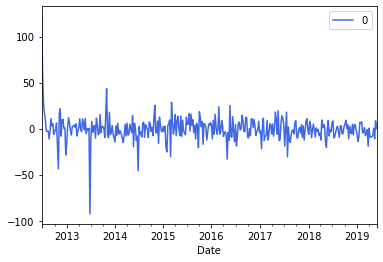

In [38]:
# Visualize residuals/error
residuals = pd.DataFrame(SARIMAX_fit.resid)
residuals.plot(color='royalblue')
plt.show();

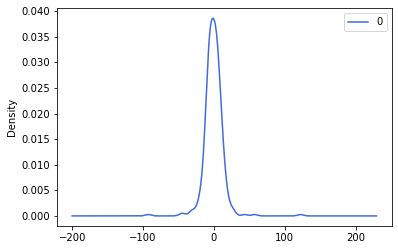

In [39]:
# Check for linearity
residuals = pd.DataFrame(SARIMAX_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()


Based on the first graph above, we see residuals centered and concentrated at 0, though with more variance than is ideal. With a mean at approximately 0, the second graph shows that our model is mostly linear.

**Test Predictions**

We know that this ARIMA model yielded our best test predictions from its RMSE and AIC score, but let's visualize our predictions compared to the true data.

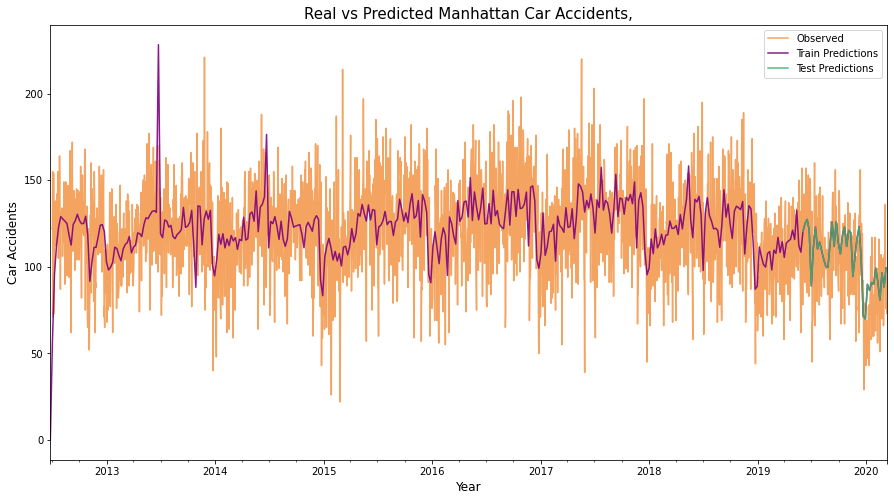

In [22]:
# Plot real vs predicted values
fix,ax = plt.subplots(figsize=(15, 8))

# Plot observed values
ax = df_man['Accidents_Man'].plot(label='Observed', color='sandybrown')

# Plot predicted train values
SARIMAX_pred_train = SARIMAX_fit.predict(start='2012-07-01', end='2020-03-13', exog = test.iloc[:,1], dynamic=False)
SARIMAX_pred_train.plot(ax=ax, label='Train Predictions', alpha=0.9, color='purple')

# Plot predicted values
SARIMAX_pred.plot(ax=ax, label='Test Predictions', alpha=0.9, color='mediumseagreen')

# Set axes labels and title
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Car Accidents',size=12)
ax.set_title('Real vs Predicted Manhattan Car Accidents,', size=15)

plt.legend()
plt.show()

# Forecasting

Now that we see how our data performed on our train and test data, it is time to apply it to the future.

## July 1, 2021 through the end of 2021

As discussed in the EDA notebook, we will use our current model to predict accident numbers starting on July 1, 2021, assuming a 25% decrease from our model predictions.

In [23]:
# Create df including all Queens data, not only pre-Covid like we've been using for modeling
df_man_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Qns', 'Accidents_Bkln', 'Accidents_SI',
                               'Accidents_Total'])

In [24]:
# Create exog data for forecast through 6/30/2022--whether or not there is a holiday that week
exog = pd.DataFrame(pd.date_range(start='2019-06-09', periods=160, freq='W'))
exog.rename(columns={0:'Date'},inplace=True)
exog.set_index('Date',inplace=True)


exog['Holiday'] = 0

# July 4th
exog.loc['2019-06-30']['Holiday'] = 1
exog.loc['2020-06-28']['Holiday'] = 1
exog.loc['2021-07-04']['Holiday'] = 1
exog.loc['2022-06-26']['Holiday'] = 1

# Xmas Eve, Xmas
exog.loc['2019-12-22']['Holiday'] = 1
exog.loc['2020-12-20']['Holiday'] = 1
exog.loc['2021-12-19']['Holiday'] = 1

# New Years Eve, New Years Day
exog.loc['2019-12-29']['Holiday'] = 1
exog.loc['2020-12-27']['Holiday'] = 1
exog.loc['2021-12-26']['Holiday'] = 1

# Thanksgiving, Post-Thanksgiving
exog.loc['2019-11-24']['Holiday'] = 1
exog.loc['2020-11-22']['Holiday'] = 1
exog.loc['2021-11-21']['Holiday'] = 1

# MLK Day
exog.loc['2020-01-19']['Holiday'] = 1
exog.loc['2021-01-17']['Holiday'] = 1
exog.loc['2022-01-16']['Holiday'] = 1

# President's Day
exog.loc['2020-02-16']['Holiday'] = 1
exog.loc['2021-02-14']['Holiday'] = 1
exog.loc['2022-02-20']['Holiday'] = 1

# Easter
exog.loc['2020-04-12']['Holiday'] = 1
exog.loc['2021-04-04']['Holiday'] =1
exog.loc['2022-04-17']['Holiday'] = 1

# Memorial Day
exog.loc['2020-05-24']['Holiday'] = 1
exog.loc['2021-05-30']['Holiday'] = 1
exog.loc['2022-05-29']['Holiday'] = 1

# Labor Day
exog.loc['2019-09-01']['Holiday'] = 1
exog.loc['2020-09-06']['Holiday'] = 1
exog.loc['2021-09-05']['Holiday'] = 1

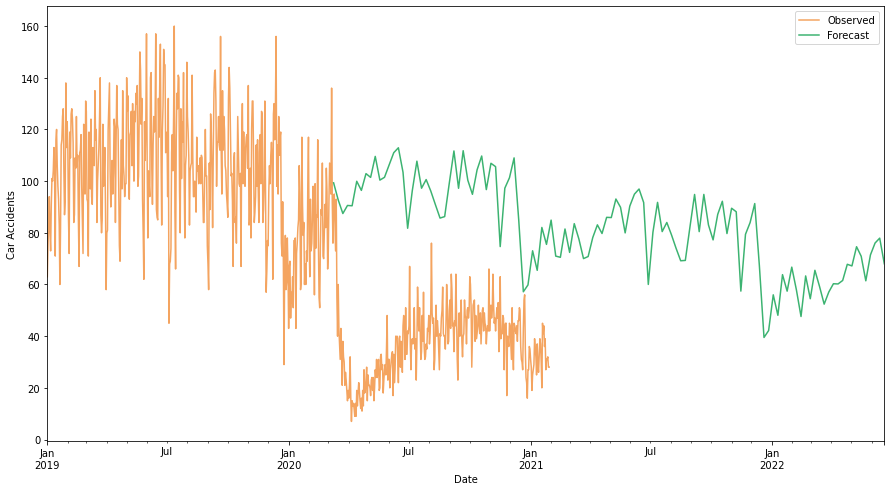

In [25]:
# Generate forcast from 3/14/20-6/30/2022 (120 weeks, 838 days)
forecast = SARIMAX_fit.forecast(steps=160,exog=exog['Holiday'])
pred_values = pd.DataFrame(forecast)
pred_values = pred_values[0]
pred_values

# Plot forecast
fix,ax = plt.subplots(figsize=(15, 8))
ax = df_man_total['Accidents_Man']['2019-01-01':].plot(label='Observed', color='sandybrown')
pred_values['2020-03-14':].plot(ax=ax, label='Forecast',color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

The above shows us what our predictions would have been through the end of 2021, if it hadn't been for the COVID-19 pandemic. Now let's look at what our actual predictions are, given what we do know about te pandemic and related predictions discussed earlier.

In [30]:
# Create df of adjusted COVID predictions
# Starting week of 7/1/21, 75% of original predictions
TS_pred_cov = pred_values['2021-07-04':] * 0.75

# Create linear data connecting last known data point and predicted data linearly
# Create df for connection data
connection = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-07-04', freq='W'))
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-07-04', freq='W'))

# Find how much the accident count will rise each day
# There are 22 weeks between 1/29/21 and 7/4/21 (weekly values)
weekly_interval=(TS_pred_cov['2021-07-04'] - df_man_total['Accidents_Man']['2021-01-29'])/22

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_man_total['Accidents_Man']['2021-01-29']
for num in range(0,23):
    i+=weekly_interval
    connection_forecasts.append(i)

# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts
# jan30 = pd.DataFrame(data=[29],columns=['Forecast'])
# jan30['Date'] = [pd.to_datetime('2021-01-30')]
# jan30.set_index('Date',drop=True,inplace=True)
# connection = pd.concat([jan30,connection])

# Make date index of connection df
connection.set_index('Date', inplace=True)
connection.drop(columns=0,inplace=True)


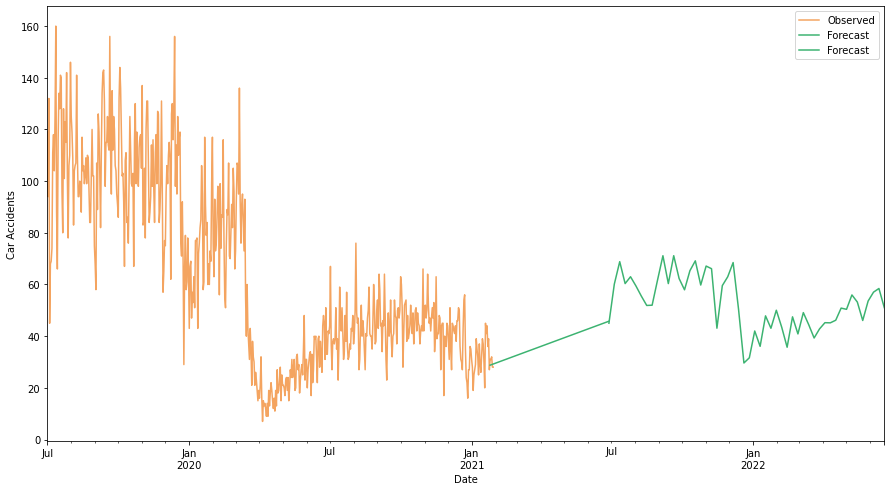

In [29]:
fix,ax = plt.subplots(figsize=(15, 8))

# Plot known data
ax = df_man_total['Accidents_Man']['2019-07-01':].plot(label='Observed', color='sandybrown')

# Plot predicted data based on model, starting 7/1/20, 75% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast',color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

The above shows our best predictions for car accidents in Manhattan with an ARIMA-type model, which is a SARIMAX model. In a separate notebook, we will create a Facebook Prophet model and compare it to this one.

# Export Data

In our FB Prophet notebook, we saw that our SARIMAX model was the best one for our Manhattan data. We will therefore export data from this model to use on our Streamlit dashboard.

In [75]:
# Set daily predictions as their weekly mean

# Connection df
connection_daily = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-07-03', freq='D'))
connection_daily.rename(columns={0:'Date'},inplace=True)
connection_daily.set_index('Date',inplace=True)

daily_forecast = [29]
for index,row in connection.iterrows():
    daily_forecast.extend([connection.loc[index]['Forecast']] * 7)

del daily_forecast[-7:]

connection_daily['Forecast'] = daily_forecast

# Predictions df
pred_daily = pd.DataFrame(pd.date_range(start='2021-07-04', end='2022-06-30', freq='D'))
pred_daily.rename(columns={0:'Date'},inplace=True)
pred_daily.set_index('Date',inplace=True)

TS_pred_cov = pd.DataFrame(data = TS_pred_cov)

daily_pred = []
for index,row in TS_pred_cov.iterrows():
    daily_pred.extend([TS_pred_cov.loc[index][0]] * 7)

del daily_pred[-2:]

pred_daily['Forecast'] = daily_pred
            

In [76]:
# Create one df combining known and predicted accident frequencies
# Round forecasts to integers 
data_preds_man = pd.concat([df_man_total['Accidents_Man'],round(connection_daily['Forecast']),round(pred_daily['Forecast'])])
data_preds_man.to_csv('Data/data_preds_man.csv')